In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as norm
import pandas as pd
from matplotlib.gridspec import SubplotSpec
from scipy import stats
from sklearn.linear_model import LinearRegression

import yt
import seaborn as sns

In [2]:
import caesar as caesar
# !pip3 install yt

In [3]:
#!yt version

In [4]:
caesar?

In [5]:
snapnum,snapz=caesar.progen.z_to_snap(redshift=0)

In [6]:
snapnum

151

In [7]:
snapz

0.0

In [8]:
obj.galaxies

NameError: name 'obj' is not defined

In [ ]:
len(obj.galaxies)

### Define functions

In [9]:
def read_caesar(caesarfilename):
    '''Function that reads SIMBA files and outputs the fields in a data frame'''
    
    groups=caesar.load(caesarfilename)
    Ngal=len(groups.galaxies)
    idx=np.zeros(Ngal);cent=np.zeros(Ngal);sfr=np.zeros(Ngal);rdisk=np.zeros(Ngal)
    atomic_H_mass=np.zeros(Ngal);molecular_H_mass=np.zeros(Ngal);Mstar=np.zeros(Ngal);Mhalo=np.zeros(Ngal)
    Shalo=np.zeros(Ngal)
    BoverT=np.zeros(Ngal); stellar_age=np.zeros(Ngal); galaxy_angular_momentum=np.zeros(Ngal)
    
    for i,galaxy in enumerate(groups.galaxies):
        idx[i] = galaxy.GroupID
        cent[i] = (galaxy.central).astype(int)
        sfr[i] = galaxy.sfr
        rdisk[i]=galaxy.radii['stellar_half_mass']
        Mstar[i] = galaxy.masses['stellar_30kpc']
        atomic_H_mass[i] = galaxy.masses['HI_30kpc']
        molecular_H_mass[i] = galaxy.masses['H2_30kpc'] 
        BoverT[i] = galaxy.rotation['stellar_BoverT']
        stellar_age[i] = galaxy.ages['mass_weighted']
        galaxy_angular_momentum[i] = np.linalg.norm(galaxy.rotation['stellar_L'])
        Mhalo[i]=galaxy.halo.masses['total']
        Shalo[i]=galaxy.halo.virial_quantities['spin_param']
    
    df=pd.DataFrame({'GID':idx,'central':cent,'galaxy_mass':Mstar,'galaxy_size':rdisk, 'SFR':sfr,
                     'atomic_H_mass':atomic_H_mass,'molecular_H_mass':molecular_H_mass, 
                     'BoverT': BoverT, 'stellar_age': stellar_age, 'galaxy_angular_momentum':galaxy_angular_momentum,
                     'Mhalo':Mhalo, 'Shalo' : Shalo})
    
    return df

In [25]:
def log_mass_size(df):
    '''
    Converts to log10 non-zero size and mass entries (without distinguishing galaxy type)
    output: df with new columns of log mass, log size added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['galaxy_mass'] > 0]

#     #subhalo_flag = subhalos[‘SubhaloFlag’]
#     if type_of_galaxy == 'central':
#         df=df[df['subhalo_flag']==True]
#     elif type_of_galaxy == 'satellite':
#         df=df[df['subhalo_flag']==False]
#     else: 
#         print("type_of_galaxy must be set to central or satellite")

    #since we got rid of all zero mass we can just take the log10
    df['galaxy_mass_log']=np.log10(df['galaxy_mass'])
    df['galaxy_size_log']=np.log10(df['galaxy_size'])
    df['Mhalo_log']=np.log10(df['Mhalo'])
    df['galaxy_angular_momentum_log']=np.log10(df['galaxy_angular_momentum'])

    return df

In [10]:
def log_SFR(df):
    '''
    Converts to log10 non-zero SFR entries (without distinguishing galaxy type)
    output: df with new columns of log SFR added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['SFR'] > 0]

    #since we got rid of all zero mass we can just take the log10
    df['SFR_log']=np.log10(df['SFR'])

    return df

In [11]:
# function to return the base 10 logarithm of non-zero values
def return_log(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return 0

In [12]:
# function to return the base 10 logarithm of non-zero values
def return_log_SFR(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return -2

In [13]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

### Define data frame

In [15]:
df_SIMBA = read_caesar('m100n1024_151.hdf5')

yt : [INFO     ] 2021-12-09 16:36:22,706 Opening m100n1024_151.hdf5
yt : [INFO     ] 2021-12-09 16:36:22,788 Found 464043 halos
yt : [INFO     ] 2021-12-09 16:36:22,811 Found 55609 galaxies


In [16]:
df_SIMBA.head(2) # total of 55,609 row entries (galaxies)

,GID,central,galaxy_mass,galaxy_size,SFR,atomic_H_mass,molecular_H_mass,BoverT,stellar_age,galaxy_angular_momentum,Mhalo,Shalo
0,0.0,1.0,2.504664e+12,25.092316,0.000000,7.027060e+07,0.000000e+00,0.977234,11.665147,3.543781e+14,1.060091e+15,inf
1,1.0,1.0,3.621600e+12,11.327452,32.495613,1.783766e+09,2.515199e+10,0.683872,10.086016,2.026489e+15,4.434884e+14,0.002251


In [17]:
# remove the 807 infinity entries from Shalo column (halo spin); all the 807 infinity entries belong to satellite galaxies
df_SIMBA = df_SIMBA.loc[df_SIMBA.Shalo<np.inf,:]

In [18]:
df_SIMBA.shape

(54802, 12)

In [19]:
df_SIMBA['central'].value_counts()

1.0    35841
0.0    18961
Name: central, dtype: int64

In [20]:
# add a column that labels galaxy type
df_SIMBA['galaxy_type'] = df_SIMBA.apply(lambda row: 'central' if row['central']==True else 'satellite', axis=1)


In [21]:
df_SIMBA.dtypes

GID                        float64
central                    float64
galaxy_mass                float64
galaxy_size                float64
SFR                        float64
atomic_H_mass              float64
molecular_H_mass           float64
BoverT                     float64
stellar_age                float64
galaxy_angular_momentum    float64
Mhalo                      float64
Shalo                      float64
galaxy_type                 object
dtype: object

In [22]:
df_SIMBA['galaxy_type'].value_counts()

central      35841
satellite    18961
Name: galaxy_type, dtype: int64

### Logarithmic scale of size, mass, SFR, Mhalo and angular momentum

In [26]:
df_SIMBA_log=log_mass_size(df_SIMBA)

In [27]:
df_SIMBA_log.head(2)

,GID,central,galaxy_mass,galaxy_size,SFR,atomic_H_mass,molecular_H_mass,BoverT,stellar_age,galaxy_angular_momentum,Mhalo,Shalo,galaxy_type,galaxy_mass_log,galaxy_size_log,Mhalo_log,galaxy_angular_momentum_log
1,1.0,1.0,3.621600e+12,11.327452,32.495613,1.783766e+09,2.515199e+10,0.683872,10.086016,2.026489e+15,4.434884e+14,0.002251,central,12.558900,1.054132,14.646882,15.306744
2,2.0,1.0,1.570857e+12,14.278415,0.000000,1.322210e+08,0.000000e+00,0.909795,11.927602,3.301967e+14,6.903581e+14,0.002041,central,12.196137,1.154680,14.839074,14.518773


In [28]:
# add a column with the logarithmic value of SFR
df_SIMBA_log['SFR_log'] = df_SIMBA_log.apply(lambda row: return_log_SFR(row, 'SFR'), axis=1)

In [29]:
df_SIMBA_log.head(2)

,GID,central,galaxy_mass,galaxy_size,SFR,atomic_H_mass,molecular_H_mass,BoverT,stellar_age,galaxy_angular_momentum,Mhalo,Shalo,galaxy_type,galaxy_mass_log,galaxy_size_log,Mhalo_log,galaxy_angular_momentum_log,SFR_log
1,1.0,1.0,3.621600e+12,11.327452,32.495613,1.783766e+09,2.515199e+10,0.683872,10.086016,2.026489e+15,4.434884e+14,0.002251,central,12.558900,1.054132,14.646882,15.306744,1.511825
2,2.0,1.0,1.570857e+12,14.278415,0.000000,1.322210e+08,0.000000e+00,0.909795,11.927602,3.301967e+14,6.903581e+14,0.002041,central,12.196137,1.154680,14.839074,14.518773,-2.000000


#### Gas fraction

In [28]:
df_SIMBA_log['neutral_H_mass']=(df_SIMBA_log['atomic_H_mass']+df_SIMBA_log['molecular_H_mass'])
df_SIMBA_log['baryon_mass']=df_SIMBA_log['neutral_H_mass']+df_SIMBA_log['galaxy_mass']
df_SIMBA_log['gas_fraction']=df_SIMBA_log['neutral_H_mass']/df_SIMBA_log['baryon_mass']

In [30]:
df_SIMBA_log.head(2)

,GID,central,galaxy_mass,galaxy_size,SFR,atomic_H_mass,molecular_H_mass,BoverT,stellar_age,galaxy_angular_momentum,Mhalo,Shalo,galaxy_type,galaxy_mass_log,galaxy_size_log,Mhalo_log,galaxy_angular_momentum_log,SFR_log
1,1.0,1.0,3.621600e+12,11.327452,32.495613,1.783766e+09,2.515199e+10,0.683872,10.086016,2.026489e+15,4.434884e+14,0.002251,central,12.558900,1.054132,14.646882,15.306744,1.511825
2,2.0,1.0,1.570857e+12,14.278415,0.000000,1.322210e+08,0.000000e+00,0.909795,11.927602,3.301967e+14,6.903581e+14,0.002041,central,12.196137,1.154680,14.839074,14.518773,-2.000000


In [31]:
# choose only galaxies that have a stellar mass of logMstar>9 and logMstar<11.5


df_SIMBA_largebin = df_SIMBA_log.loc[(df_SIMBA_log.galaxy_mass_log>=9.0)  
                                     & (df_SIMBA_log.galaxy_mass_log<11.5)
                                     , :] 
                                         

In [32]:
df_SIMBA_largebin.head(2)

,GID,central,galaxy_mass,galaxy_size,SFR,atomic_H_mass,molecular_H_mass,BoverT,stellar_age,galaxy_angular_momentum,Mhalo,Shalo,galaxy_type,galaxy_mass_log,galaxy_size_log,Mhalo_log,galaxy_angular_momentum_log,SFR_log
37,37.0,1.0,2.416473e+11,33.342163,0.0,1.340364e+08,0.0,0.833175,11.071860,2.359526e+14,1.189718e+14,0.003531,central,11.383182,1.522994,14.075444,14.372825,-2.0
54,54.0,1.0,2.999025e+11,18.097645,0.0,5.141249e+08,0.0,0.911513,10.796082,9.038549e+13,1.682830e+14,0.005580,central,11.476980,1.257622,14.226040,13.956099,-2.0


In [33]:
df_SIMBA_largebin['galaxy_type'].value_counts() # there are 25,813 centrals in the mass range [9.0,11.5]

central      25813
satellite    14359
Name: galaxy_type, dtype: int64

In [34]:
((df_SIMBA_log.galaxy_mass_log>=9.0) & (df_SIMBA_log.galaxy_mass_log<=11.0)).sum()

39284

In [33]:
40172-33946 # 6,226 more galaxies included when the upper limit goes from galaxy_mass_log=11 to 11.5

6226

In [34]:
df_SIMBA_largebin.SFR_log.max()

1.382496643792485

In [35]:
df_SIMBA_largebin.SFR_log.min()

-5.946548143370941

In [36]:
df_SIMBA_largebin.shape

(40172, 21)

In [37]:
np.count_nonzero(df_SIMBA_log['galaxy_size_log']) # this means that there are no size zero entries in Simba

54802

#### Galaxies in of all stellar masses in the range [9.0, 11.5]

In [35]:
df_SIMBA_largebin

,GID,central,galaxy_mass,galaxy_size,SFR,atomic_H_mass,molecular_H_mass,BoverT,stellar_age,galaxy_angular_momentum,Mhalo,Shalo,galaxy_type,galaxy_mass_log,galaxy_size_log,Mhalo_log,galaxy_angular_momentum_log,SFR_log
37,37.0,1.0,2.416473e+11,33.342163,0.000000,1.340364e+08,0.000000e+00,0.833175,11.071860,2.359526e+14,1.189718e+14,0.003531,central,11.383182,1.522994,14.075444,14.372825,-2.000000
54,54.0,1.0,2.999025e+11,18.097645,0.000000,5.141249e+08,0.000000e+00,0.911513,10.796082,9.038549e+13,1.682830e+14,0.005580,central,11.476980,1.257622,14.226040,13.956099,-2.000000
60,60.0,1.0,3.142857e+11,16.777937,0.000000,3.788412e+07,0.000000e+00,0.937238,11.381847,9.810987e+13,1.607073e+14,0.002178,central,11.497325,1.224739,14.206036,13.991713,-2.000000
66,66.0,1.0,3.071179e+11,16.420738,0.000000,3.984014e+00,0.000000e+00,0.966776,9.708078,1.143952e+13,3.879342e+13,0.000831,central,11.487305,1.215393,13.588758,13.058408,-2.000000
69,69.0,1.0,2.723477e+11,19.360113,0.000000,2.296919e+08,0.000000e+00,0.953281,11.225251,1.598248e+14,1.206225e+14,0.003311,central,11.435124,1.286908,14.081428,14.203644,-2.000000
71,71.0,1.0,3.130846e+11,14.830811,0.000000,2.605707e+08,0.000000e+00,0.927313,11.009992,2.136688e+14,1.429622e+14,0.005354,central,11.495662,1.171165,14.155221,14.329741,-2.000000
75,75.0,1.0,2.876746e+11,16.736425,0.000000,3.396300e+01,0.000000e+00,0.990524,10.705149,1.844097e+13,7.882524e+13,0.005726,central,11.458902,1.223663,13.896665,13.265784,-2.000000
79,79.0,0.0,3.135891e+11,13.716623,0.000000,3.798557e+08,3.380003e+07,0.885586,11.312620,8.250724e+13,1.087991e+14,0.012787,satellite,11.496361,1.137247,14.036625,13.916492,-2.000000
80,80.0,0.0,2.296272e+11,23.276918,0.000000,4.727811e+03,0.000000e+00,0.730831,10.766444,3.859826e+14,1.058428e+14,0.045474,satellite,11.361023,1.366925,14.024661,14.586568,-2.000000
86,86.0,1.0,2.979211e+11,14.124501,0.000000,1.699490e+08,0.000000e+00,0.954017,11.415852,4.938353e+12,4.000421e+13,0.000870,central,11.474101,1.149973,13.602106,12.693582,-2.000000


## Correlations for all masses

In [36]:
central_SIMBA = df_SIMBA_largebin.loc[df_SIMBA_largebin["galaxy_type"] == 'central',["galaxy_mass_log", "galaxy_size_log",'SFR', 'SFR_log', 'atomic_H_mass', 'molecular_H_mass','gas_fraction','BoverT', 'galaxy_angular_momentum',"galaxy_angular_momentum_log",'Mhalo_log', 'Shalo']]
print(central_SIMBA.shape)
central_galaxies_mass=central_SIMBA["galaxy_mass_log"]
central_galaxies_size=central_SIMBA["galaxy_size_log"]
central_galaxies_SFR=central_SIMBA["SFR"]
central_galaxies_SFR_log=central_SIMBA["SFR_log"]
central_galaxies_atomic_H_mass=central_SIMBA["atomic_H_mass"]
central_galaxies_molecular_H_mass=central_SIMBA["molecular_H_mass"]
central_galaxies_gas_fraction=central_SIMBA["gas_fraction"]
central_galaxies_BoverT=central_SIMBA["BoverT"]
central_galaxies_galaxy_angular_momentum=central_SIMBA["galaxy_angular_momentum"]
central_galaxies_galaxy_angular_momentum_log=central_SIMBA["galaxy_angular_momentum_log"]
central_galaxies_Mhalo=central_SIMBA["Mhalo_log"]
central_galaxies_Shalo=central_SIMBA["Shalo"]

satellite_SIMBA = df_SIMBA_largebin.loc[df_SIMBA_largebin["galaxy_type"] == 'satellite', ["galaxy_mass_log","galaxy_size_log",'SFR','SFR_log','atomic_H_mass', 'molecular_H_mass', 'gas_fraction', 'BoverT','galaxy_angular_momentum', 'Mhalo_log', 'Shalo']]
satellite_galaxies_mass=satellite_SIMBA["galaxy_mass_log"]
satellite_galaxies_size=satellite_SIMBA["galaxy_size_log"]
satellite_galaxies_SFR=satellite_SIMBA["SFR"]
satellite_galaxies_SFR_log=satellite_SIMBA["SFR_log"]
satellite_galaxies_atomic_H_mass=satellite_SIMBA["atomic_H_mass"]
satellite_galaxies_molecular_H_mass=satellite_SIMBA["molecular_H_mass"]
satellite_galaxies_gas_fraction=satellite_SIMBA["gas_fraction"]
satellite_galaxies_BoverT=satellite_SIMBA["BoverT"]
satellite_galaxies_galaxy_angular_momentum=satellite_SIMBA["galaxy_angular_momentum"]
satellite_galaxies_Mhalo=satellite_SIMBA["Mhalo_log"]
satellite_galaxies_Shalo=satellite_SIMBA["Shalo"]

(25813, 12)


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [37]:
mass_size_corr_central = round(stats.spearmanr(central_galaxies_mass, central_galaxies_size)[0], 2)
SFR_size_corr_central = round(stats.spearmanr(central_galaxies_SFR, central_galaxies_size )[0], 2)
SFR_mass_corr_central = round(stats.spearmanr(central_galaxies_SFR, central_galaxies_mass )[0], 2)

mass_size_corr_satellite = round(stats.spearmanr(satellite_galaxies_mass, satellite_galaxies_size )[0], 2)
SFR_size_corr_satellite = round(stats.spearmanr(satellite_galaxies_SFR, satellite_galaxies_size )[0], 2)
SFR_mass_corr_satellite = round(stats.spearmanr(satellite_galaxies_SFR, satellite_galaxies_mass )[0], 2)

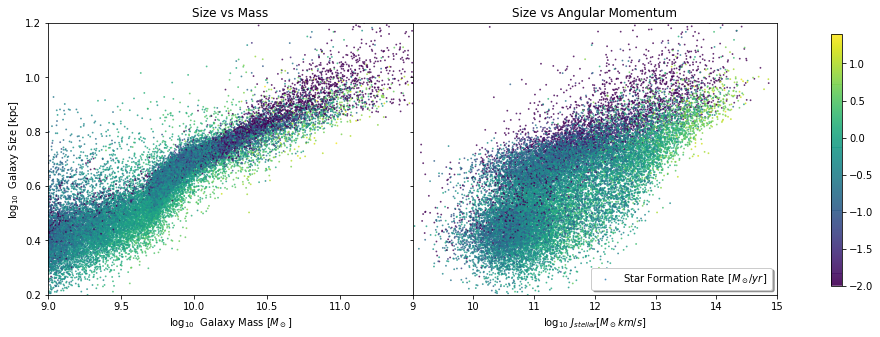

In [38]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
# fig.suptitle('SIMBA Central Galaxies: Size, Mass and Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = 'Star Formation Rate [$M_\odot / yr$] \n mass-size corr={} \n SFR-size corr={} \n SFR-mass corr={}'.format(10, mass_size_corr_central,SFR_size_corr_central,SFR_mass_corr_central )
# print(label)
im1 = ax1.scatter(central_galaxies_mass, central_galaxies_size, 
                  c = (central_galaxies_SFR_log),  s=3, marker='.', alpha=0.7, vmin=-2, vmax=1.4)#, label=label)
ax1.set_xlim([9.0, 11.5])
ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([0.2,1.2])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('$\log_{10} $  Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

label = 'Star Formation Rate [$M_\odot / yr$] '
im2 = ax2.scatter(central_galaxies_galaxy_angular_momentum_log, central_galaxies_size, 
                  c = (central_galaxies_SFR_log),  s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.4)
                  
ax2.set_xlim([9,15])
# ax2.set_xticks([ 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Angular Momentum')
ax2.set_xlabel('$\log_{10} \, \, J_{stellar} [M_\odot km/s]$')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("SIMBA_centrals_Mass_Size_AngMom_v4.jpeg", dpi=500)
plt.show()

In [39]:
central_SIMBA_pairplot = df_SIMBA_largebin.loc[df_SIMBA_largebin["galaxy_type"] == 'central',["galaxy_size_log", "galaxy_mass_log", 'Mhalo_log','BoverT', 'SFR_log', 'stellar_age', 'gas_fraction', "galaxy_angular_momentum_log"]]



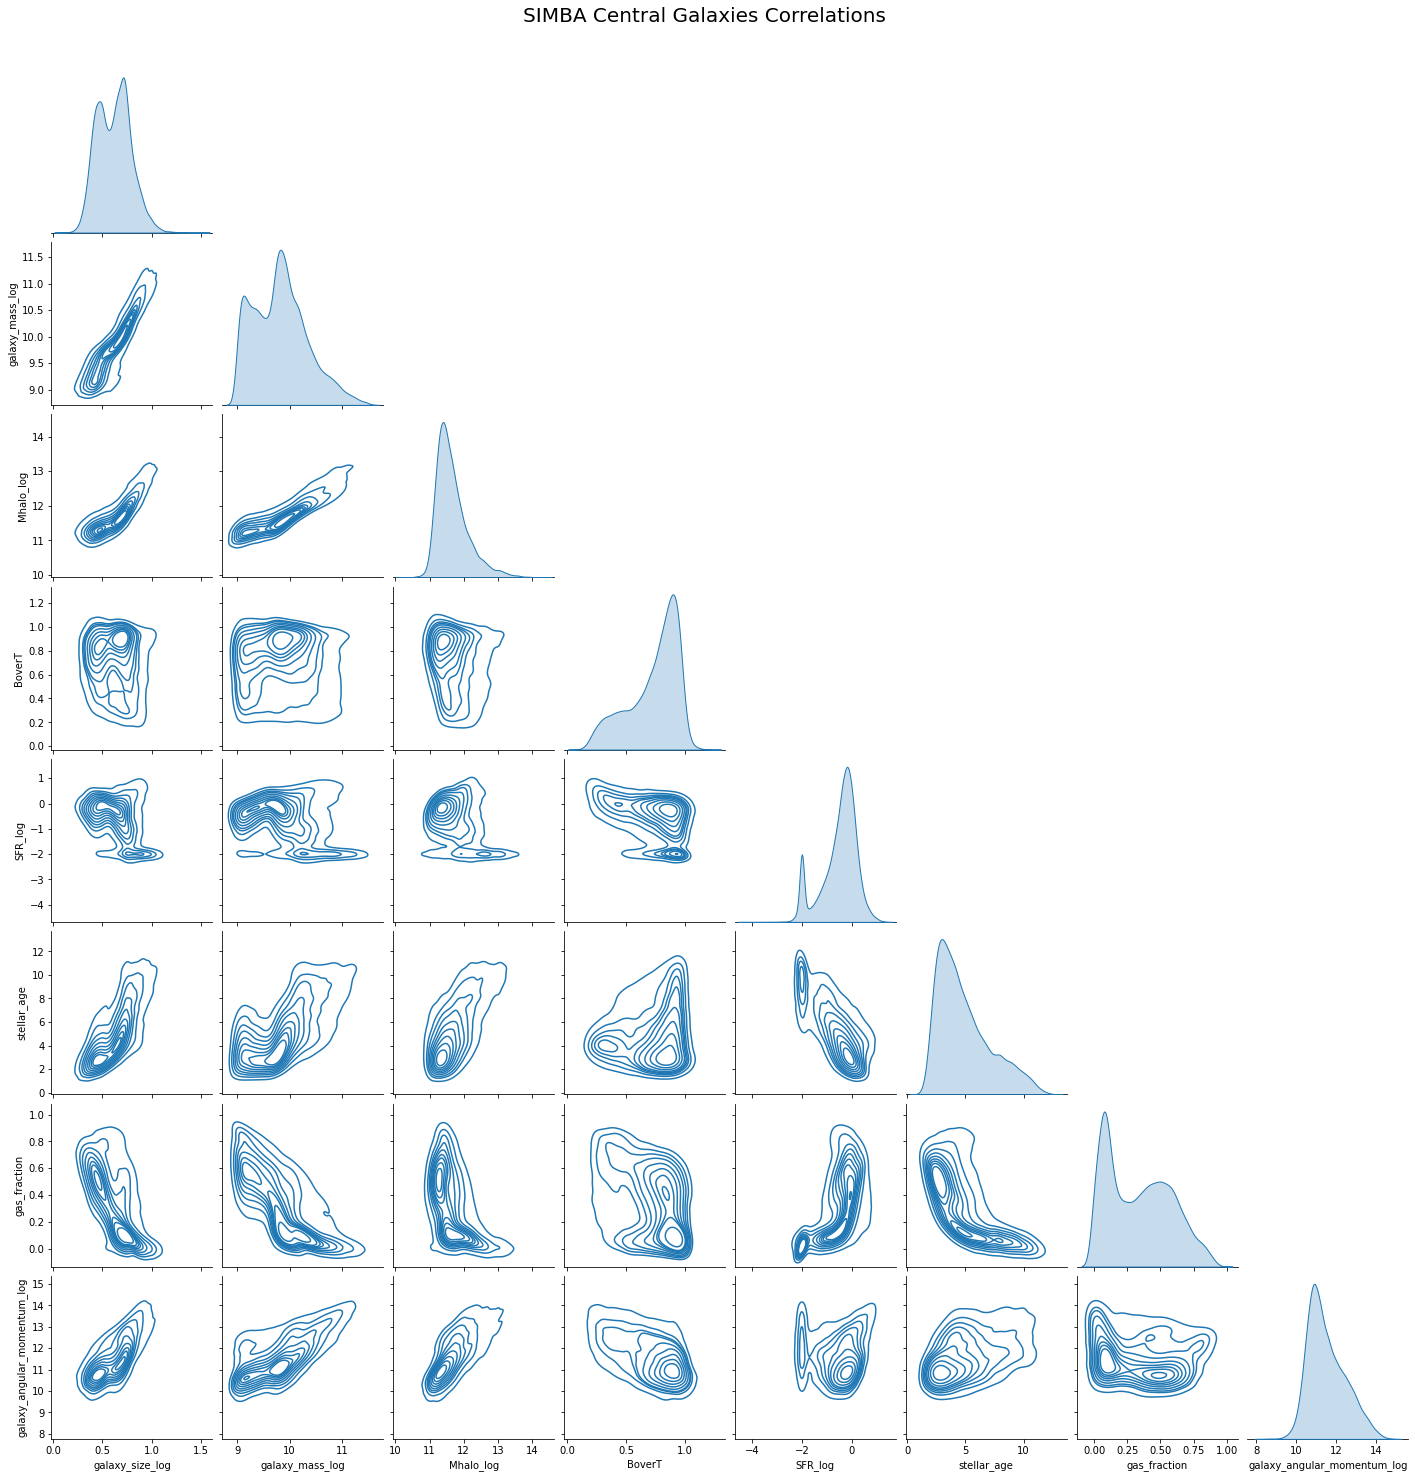

In [44]:
plot2=sns.pairplot(central_SIMBA_pairplot, kind='kde', corner=True)
plot2.fig.suptitle("SIMBA Central Galaxies Correlations ", y=1.03, fontsize=20) # y= some height>1
# plt.savefig("SIMBA_centrals_correlations.jpeg", dpi=500)
plt.show()



### <font color='blue'> 1. a. Linear Regression Model - all features

In [40]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import cross_val_predict

In [41]:
df_SIMBA_largebin.columns

Index(['GID', 'central', 'galaxy_mass', 'galaxy_size', 'SFR', 'atomic_H_mass',
       'molecular_H_mass', 'BoverT', 'stellar_age', 'galaxy_angular_momentum',
       'Mhalo', 'Shalo', 'galaxy_type', 'galaxy_mass_log', 'galaxy_size_log',
       'Mhalo_log', 'galaxy_angular_momentum_log', 'SFR_log'],
      dtype='object')

In [42]:
X = df_SIMBA_largebin.loc[df_SIMBA_largebin["galaxy_type"] == 'central',['galaxy_mass_log', 'SFR_log', 'Mhalo_log', 'gas_fraction', 'stellar_age' , 'galaxy_angular_momentum_log', 'atomic_H_mass', 'molecular_H_mass','BoverT']]


y = df_SIMBA_largebin.loc[df_SIMBA_largebin["galaxy_type"] == 'central','galaxy_size_log']

In [64]:
X = X.drop(columns=['gas_fraction'])

In [119]:
X.shape

(25813, 8)

In [120]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

In [121]:
y_pred_reg = cross_val_predict(reg, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [122]:
y_pred_reg

array([1.10478777, 1.10568892, 1.1182498 , ..., 0.50661694, 0.46653341,
       0.49345511])

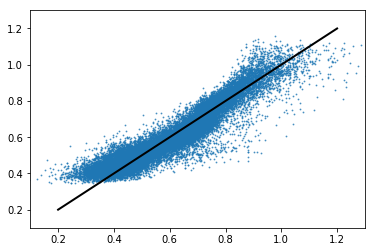

In [123]:
plt.scatter(y, y_pred_reg, s=3, marker='.', alpha=0.7)
plt.axis([0.1,1.3, 0.1,1.3])
plt.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
plt.show()

In [127]:
scores = cross_validate(reg, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10), \
                        return_train_score=True)

In [129]:
scores['test_score'].mean(), scores['test_score'].std(), scores['train_score'].mean()

(0.8675513908760399, 0.0021588240874239944, 0.8677645624180812)

### <font color='blue'> 2. Random Forest Model

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
regr = RandomForestRegressor(max_depth=10, random_state=0)
# regr.fit(X_train, y_train)

In [78]:
from sklearn.model_selection import cross_val_score

In [82]:
cv_score = cross_val_score(regr, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=10))

In [83]:
cv_score

array([0.92037869, 0.92237226, 0.92109867, 0.91514209, 0.92338965])

In [89]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# number of trees in random forest
n_estimators = [500]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Random search of parameters
rfr_grid = GridSearchCV(estimator = regr, param_grid = grid, cv=KFold(n_splits=5, shuffle=True), verbose=2, n_jobs = -1)
# Fit the model
rfr_grid.fit(X, y)
# print results
print(rfr_grid.best_params_)



Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.4min finished


{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 500}


In [90]:
scores = pd.DataFrame(rfr_grid.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_fit_time']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV

,params,mean_test_score,std_test_score,mean_fit_time
8,"{'bootstrap': True, 'max_depth': None, 'min_sa...",0.922565,0.001847,67.456674
7,"{'bootstrap': True, 'max_depth': None, 'min_sa...",0.922292,0.001942,80.730905
5,"{'bootstrap': True, 'max_depth': 10, 'min_samp...",0.922022,0.001777,53.523017
6,"{'bootstrap': True, 'max_depth': None, 'min_sa...",0.921957,0.001889,90.155328
4,"{'bootstrap': True, 'max_depth': 10, 'min_samp...",0.921811,0.001865,53.411238
3,"{'bootstrap': True, 'max_depth': 10, 'min_samp...",0.921525,0.001799,53.185867
2,"{'bootstrap': True, 'max_depth': 5, 'min_sampl...",0.895820,0.002309,29.213041
1,"{'bootstrap': True, 'max_depth': 5, 'min_sampl...",0.895774,0.002331,28.640759
0,"{'bootstrap': True, 'max_depth': 5, 'min_sampl...",0.895763,0.002332,28.042918


### VA: this now takes a lot of time, recommend reducing n_estimators

In [91]:
#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred = cross_val_predict(rfr_grid.best_estimator_, X, y, \
                           cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [94]:
cv_score = cross_validate(rfr_grid.best_estimator_, X, y, \
                           cv=KFold(n_splits=5, shuffle=True, random_state=10), \
                          return_train_score = True) # cv score in all data? Yes :)

In [95]:
cv_score

{'fit_time': array([43.97500086, 43.94405723, 44.10982513, 43.90896988, 44.15714192]),
 'score_time': array([0.2732861 , 0.2731216 , 0.27243495, 0.27365613, 0.27797818]),
 'test_score': array([0.9210215 , 0.92453286, 0.92342428, 0.91578831, 0.92369325]),
 'train_score': array([0.97099549, 0.97052253, 0.97077514, 0.97129872, 0.97084368])}

In [96]:
cv_score['test_score'].mean(), cv_score['train_score'].mean()

(0.9216920388429888, 0.9708871128147015)

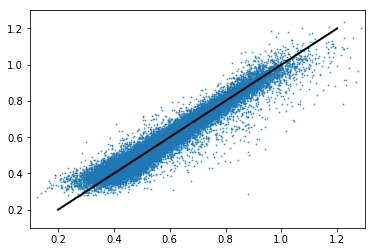

In [97]:
plt.scatter(y, y_pred, s=3, marker='.', alpha=0.7)
plt.axis([0.1,1.3, 0.1,1.3])
plt.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
plt.show()


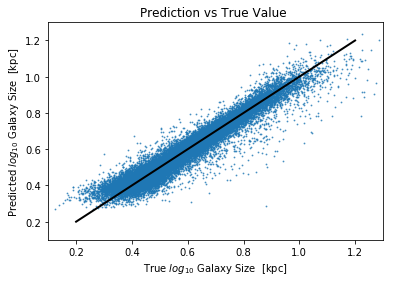

In [98]:
plt.scatter(y, y_pred, s=3, marker='.', alpha=0.7)
plt.axis([0.1,1.3, 0.1,1.3])
plt.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value ')
plt.xlabel('True $ log_{10} $ Galaxy Size  [kpc] ')
plt.ylabel(' Predicted $ log_{10} $ Galaxy Size  [kpc]  ')
# plt.savefig('Prediction_vs_True.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

### VA, important points:
    
Cross validation syntax (no need to split; use return_train_score with cross_validate function)

Shuffling is essential when doing CV otherways ordered structure is retained; use KFold(cv = 5, shuffle = True) 

I obtain different results: from 0.87 with linear model, one feature; 0.87 with linear model, all features, and finally 0.92 for RF, all features.

To be checked!

In [220]:
rfr_grid.best_estimator_.score(X_test,y_test)

0.9212630271040382

In [221]:
rfr_grid.best_estimator_.score(X_train,y_train)

0.9485421024349802

### Feature Importances MDI

In [222]:
import time

start_time = time.time()
importances = rfr_grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr_grid.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.015 seconds


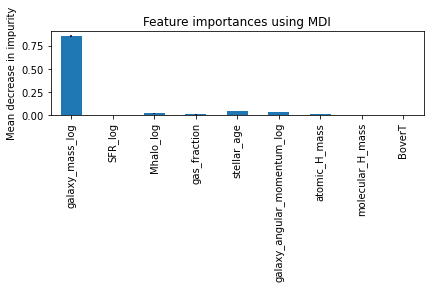

In [223]:
feature_names = X_test.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)



### Feature Importances Permutation

In [224]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rfr_grid.best_estimator_, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 0.888 seconds


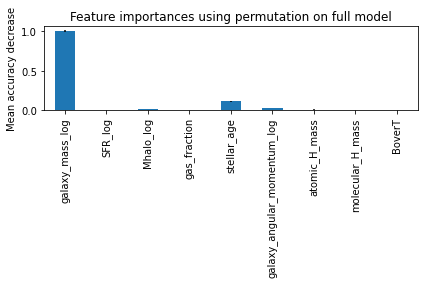

In [225]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("Feature_Importances_Permutation.jpeg", dpi=500)

plt.show()

### <font color='blue'> 1. b. Linear Regression Model - only stellar mass_log and its powers

In [130]:
X_sm = X.loc[:, ['galaxy_mass_log']]

In [131]:
X_sm.head(2)

,galaxy_mass_log
37,11.383182
54,11.476980


In [132]:
reg_stellar_mass = LinearRegression()

In [133]:
reg_sm_scores = cross_validate(reg_stellar_mass, X, y, \
                               cv = KFold(n_splits=5, shuffle=True, random_state=10), \
                              return_train_score = True)

In [134]:
reg_sm_scores

{'fit_time': array([0.04296613, 0.02663994, 0.01935792, 0.018677  , 0.01867914]),
 'score_time': array([0.00268316, 0.00100732, 0.00089431, 0.0008328 , 0.00080681]),
 'test_score': array([0.86781544, 0.86711869, 0.86834748, 0.86390487, 0.87057046]),
 'train_score': array([0.86769596, 0.86788678, 0.86757733, 0.8686491 , 0.86701365])}

In [135]:
# y_pred_reg_stellar=reg_stellar_mass.predict(X_test_stellar_mass)
y_pred_reg_stellar = cross_val_predict(reg_stellar_mass, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

### VA: Comparing linear model with one feature to linear model with all features

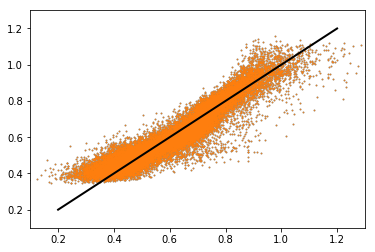

In [138]:
plt.scatter(y, y_pred_reg_stellar, s=3, marker='.', alpha=0.7)

plt.scatter(y, y_pred_reg, s=3, marker='.', alpha=0.7)

plt.axis([0.1,1.3, 0.1,1.3])
plt.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
plt.show()

### <font color='violet'> Adding powers of stellar mass to the model

In [112]:
from sklearn.preprocessing import PolynomialFeatures

poly_stellar = PolynomialFeatures(2, include_bias=True)

In [113]:
new_X_stellar_mass = poly_stellar.fit_transform(X_sm)

In [117]:
new_X_stellar_mass.shape

(25813, 3)

In [114]:
# y_pred_reg_stellar_poly=reg_stellar_mass_poly.predict(new_X_test_stellar_mass)

y_pred_reg_stellar_poly = cross_val_predict(reg_stellar_mass, new_X_stellar_mass, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

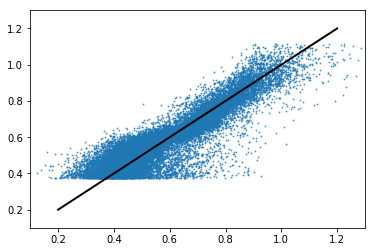

In [115]:
plt.scatter(y, y_pred_reg_stellar_poly, s=3, marker='.', alpha=0.7)
plt.axis([0.1,1.3, 0.1,1.3])
plt.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
plt.show()

### <font color='blue'> 1. c. Linear Regression Model - only halo mass_log and its powers

In [247]:
X_train_halo_mass = X_train.loc[:, ['Mhalo_log']]

In [248]:
X_test_halo_mass = X_test.loc[:, ['Mhalo_log']]

In [249]:
reg_halo_mass = LinearRegression().fit(X_train_halo_mass, y_train)
reg_halo_mass.score(X_train_halo_mass, y_train)

0.6768355489375724

In [250]:
reg_halo_mass.score(X_test_halo_mass, y_test)

0.6742374089070667

In [251]:
# y_pred_reg_halo=reg_halo_mass.predict(X_test_halo_mass)

y_pred_reg_halo = cross_val_predict(reg_halo_mass, X_test_halo_mass, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

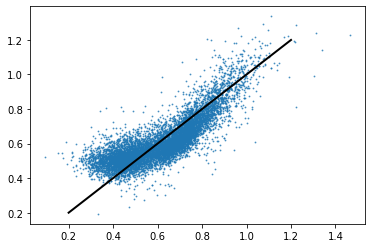

In [252]:
plt.scatter(y_test, y_pred_reg_halo, s=3, marker='.', alpha=0.7)
# plt.axis([0.1,1.3, 0.1,1.3])
plt.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
plt.show()

### Adding powers of halo mass to the model

In [253]:
poly_halo = PolynomialFeatures(2, include_bias=False)

In [254]:
new_X_train_halo_mass = poly_halo.fit_transform(X_train_halo_mass)

In [255]:
new_X_test_halo_mass = poly_halo.fit_transform(X_test_halo_mass)

In [256]:
reg_halo_mass_poly = LinearRegression().fit(new_X_train_halo_mass, y_train)

In [257]:
reg_halo_mass_poly.score(new_X_train_halo_mass, y_train)

0.6894593608329438

In [258]:
reg_halo_mass_poly.score(new_X_test_halo_mass, y_test)

0.686912014685516

In [259]:
# y_pred_reg_halo_poly=reg_halo_mass_poly.predict(new_X_test_halo_mass)

y_pred_reg_halo_poly = cross_val_predict(reg_halo_mass_poly, new_X_test_halo_mass, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

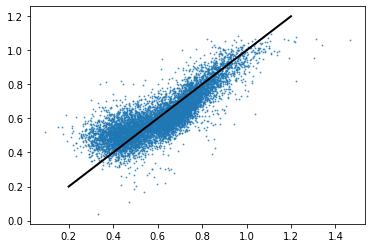

In [260]:
plt.scatter(y_test, y_pred_reg_halo_poly, s=3, marker='.', alpha=0.7)
# plt.axis([0.1,1.3, 0.1,1.3])
plt.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
plt.show()

### The figure containing all the models

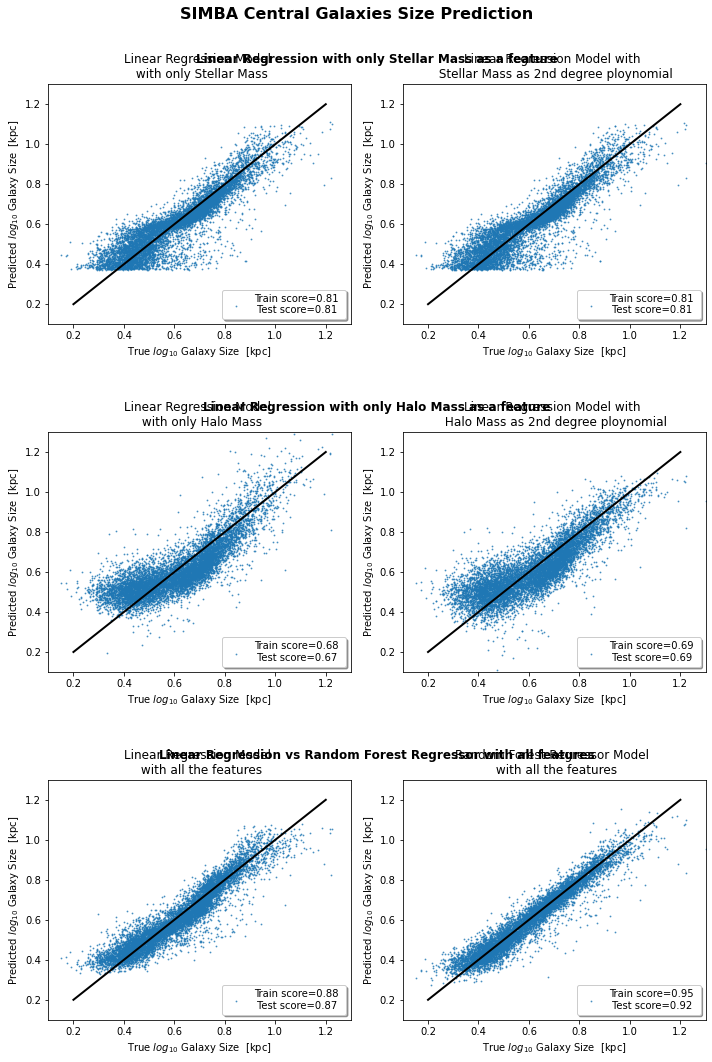

In [262]:
fig,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(10,15))
fig.suptitle('SIMBA Central Galaxies Size Prediction', fontsize=16, fontweight='bold')


label = 'Train score={} \n Test score={}'.format(round(reg_stellar_mass.score(X_train_stellar_mass, y_train), 2),round(reg_stellar_mass.score(X_test_stellar_mass, y_test), 2) )
# print(label)
im1 = ax1.scatter(y_test, y_pred_reg_stellar, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.1,1.3, 0.1,1.3])
ax1.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model \n with only Stellar Mass')
ax1.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
ax1.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax1.legend(loc='lower right', shadow=True)


label = 'Train score={} \n Test score={}'.format(round(reg_stellar_mass_poly.score(new_X_train_stellar_mass, y_train), 2),round(reg_stellar_mass_poly.score(new_X_test_stellar_mass, y_test), 2) )
im2 = ax2.scatter(y_test, y_pred_reg_stellar_poly, s=3, marker='.', alpha=0.7, label=label)
# ax2.set_xlim([9.0, 11.5])
# ax2.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax2.set_ylim([0.2,1.2])
ax2.axis([0.1,1.3, 0.1,1.3])
ax2.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax2.set_title('Linear Regression Model with \n Stellar Mass as 2nd degree ploynomial')
ax2.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
ax2.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax2.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg_halo_mass.score(X_train_halo_mass, y_train), 2),round(reg_halo_mass.score(X_test_halo_mass, y_test), 2) )
im3 = ax3.scatter(y_test, y_pred_reg_halo, s=3, marker='.', alpha=0.7, label=label)
# ax3.set_xlim([9.0, 11.5])
# ax3.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax3.set_ylim([0.2,1.2])
ax3.axis([0.1,1.3, 0.1,1.3])
ax3.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax3.set_title('Linear Regression Model \n with only Halo Mass')
ax3.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
ax3.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax3.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg_halo_mass_poly.score(new_X_train_halo_mass, y_train), 2),round(reg_halo_mass_poly.score(new_X_test_halo_mass, y_test), 2) )
im4 = ax4.scatter(y_test, y_pred_reg_halo_poly, s=3, marker='.', alpha=0.7, label=label)
# ax4.set_xlim([9.0, 11.5])
# ax4.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax4.set_ylim([0.2,1.2])
ax4.axis([0.1,1.3, 0.1,1.3])
ax4.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax4.set_title('Linear Regression Model with \n Halo Mass as 2nd degree ploynomial')
ax4.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
ax4.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax4.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
im5 = ax5.scatter(y_test, y_pred_reg, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.1,1.3, 0.1,1.3])
ax5.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax5.set_title('Linear Regression Model \n with all the features')
ax5.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(rfr_grid.best_estimator_.score(X_train,y_train), 2),round(rfr_grid.best_estimator_.score(X_test,y_test), 2) )
im6 = ax6.scatter(y_test, y_pred, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.1,1.3, 0.1,1.3])
ax6.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax6.set_title('Random Forest Regressor Model \n with all the features')
ax6.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
grid = plt.GridSpec(3, 2)
create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

fig.subplots_adjust(top=0.88, hspace=0.5, wspace=0.5)
fig.tight_layout()
# plt.savefig("SIMBA_central_size_prediction.jpeg", dpi=500)
plt.show()

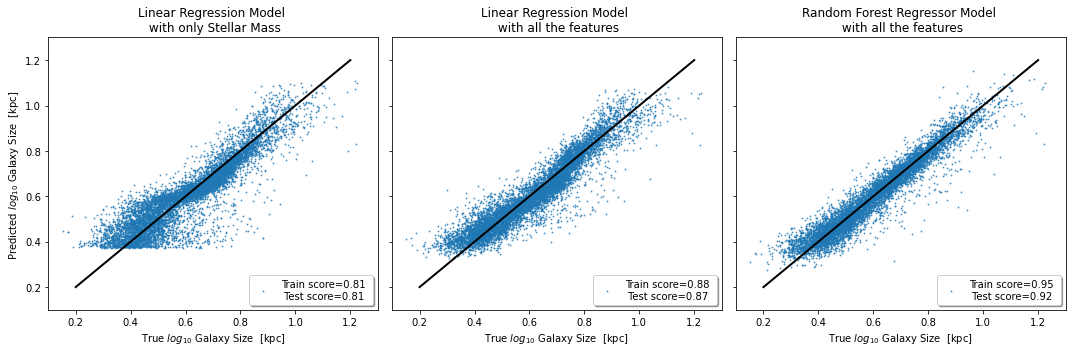

In [275]:
fig,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
# fig.suptitle('SIMBA Central Galaxies Size Prediction', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg_stellar_mass.score(X_train_stellar_mass, y_train), 2),round(reg_stellar_mass.score(X_test_stellar_mass, y_test), 2) )
# print(label)
im1 = ax1.scatter(y_test, y_pred_reg_stellar, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.1,1.3, 0.1,1.3])
ax1.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model \n with only Stellar Mass')
ax1.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
ax1.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
im5 = ax5.scatter(y_test, y_pred_reg, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.1,1.3, 0.1,1.3])
ax5.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax5.set_title('Linear Regression Model \n with all the features')
ax5.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(rfr_grid.best_estimator_.score(X_train,y_train), 2),round(rfr_grid.best_estimator_.score(X_test,y_test), 2) )
im6 = ax6.scatter(y_test, y_pred, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.1,1.3, 0.1,1.3])
ax6.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax6.set_title('Random Forest Regressor Model \n with all the features')
ax6.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("SIMBA_LR_vs_RF_size_prediction.jpeg", dpi=500)
plt.show()